<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W4/ungraded_labs/C4_W4_Lab_3_Sunspots_CNN_RNN_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Predicting Sunspots with Neural Networks

At this point in the course, you should be able to explore different network architectures for forecasting. In the previous weeks, you've used DNNs, RNNs, and CNNs to build these different models. In the final practice lab for this course, you'll try one more configuration and that is a combination of all these types of networks: the data windows will pass through a convolution, followed by stacked LSTMs, followed by stacked dense layers. See if this improves results or you can just opt for simpler models.

## Imports

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

## Utilities

In [3]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Download and Preview the Dataset

In [ ]:
# Download the Dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

In [8]:
!pwd

/Users/civye1/Documents/tensorflow-1-public/C4/W4/ungraded_labs


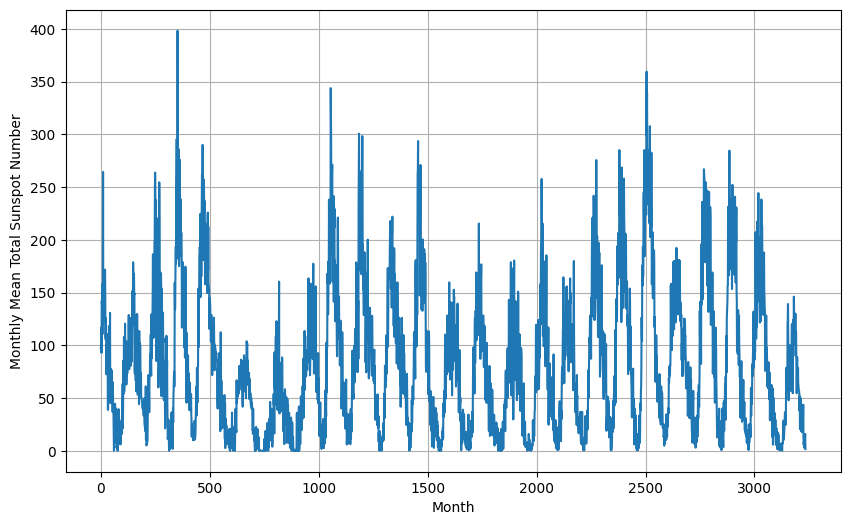

In [10]:
# Initialize lists
time_step = []
sunspots = []

# Open CSV file
with open('../Sunspots.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

## Split the Dataset

In [11]:
# Define the split time
split_time = 3000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

As mentioned in the lectures, if your results don't look good, you can try tweaking the parameters here and see if the model will learn better.

In [13]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Build the Model

You've seen these layers before and here is how it looks like when combined.

In [14]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary 
model.summary()

/Users/civye1/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │         1,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,575 (267.87 KB)

 Trainable params: 68,575 (267.87 KB)

 Non-trainable params: 0 (0.00 B)

## Tune the Learning Rate

As usual, you will want to pick an optimal learning rate.

In [15]:
# Get initial weights
init_weights = model.get_weights()

In [16]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 99.1068 - learning_rate: 1.0000e-08
Epoch 2/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 84.0682

2024-07-11 16:20:50.152685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/civye1/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 88.3718 - learning_rate: 1.1220e-08
Epoch 3/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 74.3160

2024-07-11 16:20:51.271376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 74.2564 - learning_rate: 1.2589e-08
Epoch 4/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 59.0798

2024-07-11 16:20:52.375173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 60.4715 - learning_rate: 1.4125e-08
Epoch 5/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 52.2939

2024-07-11 16:20:53.488839: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 50.9980 - learning_rate: 1.5849e-08
Epoch 6/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 44.9817

2024-07-11 16:20:54.582712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 45.0361 - learning_rate: 1.7783e-08
Epoch 7/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 43.7918

2024-07-11 16:20:55.669910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 41.0176 - learning_rate: 1.9953e-08
Epoch 8/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 35.7123

2024-07-11 16:20:56.803621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 38.3409 - learning_rate: 2.2387e-08
Epoch 9/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 33.4178

2024-07-11 16:20:57.913976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 36.7888 - learning_rate: 2.5119e-08
Epoch 10/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 36.2917

2024-07-11 16:20:59.004146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 36.0155 - learning_rate: 2.8184e-08
Epoch 11/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 31.3821

2024-07-11 16:21:00.113519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 33.3819 - learning_rate: 3.1623e-08
Epoch 12/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 31.7887

2024-07-11 16:21:01.216371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 33.2780 - learning_rate: 3.5481e-08
Epoch 13/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 31.6128

2024-07-11 16:21:02.320804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 32.4483 - learning_rate: 3.9811e-08
Epoch 14/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 32.4639

2024-07-11 16:21:03.454935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 31.2312 - learning_rate: 4.4668e-08
Epoch 15/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 28.1369

2024-07-11 16:21:04.549532: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 29.9890 - learning_rate: 5.0119e-08
Epoch 16/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 28.9139

2024-07-11 16:21:05.624594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 28.9959 - learning_rate: 5.6234e-08
Epoch 17/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 26.5940

2024-07-11 16:21:06.768695: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 28.0841 - learning_rate: 6.3096e-08
Epoch 18/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 25.7627

2024-07-11 16:21:07.910348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 27.4177 - learning_rate: 7.0795e-08
Epoch 19/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 26.4518

2024-07-11 16:21:09.000530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 25.9895 - learning_rate: 7.9433e-08
Epoch 20/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 25.1087

2024-07-11 16:21:10.085919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 25.0379 - learning_rate: 8.9125e-08
Epoch 21/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 20.7478

2024-07-11 16:21:11.162593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 23.3465 - learning_rate: 1.0000e-07
Epoch 22/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 21.6522

2024-07-11 16:21:12.261090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 22.9188 - learning_rate: 1.1220e-07
Epoch 23/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 24.1918

2024-07-11 16:21:13.351439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 23.0637 - learning_rate: 1.2589e-07
Epoch 24/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 20.5504

2024-07-11 16:21:14.419009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 21.7008 - learning_rate: 1.4125e-07
Epoch 25/100
 6/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 22.6953

2024-07-11 16:21:15.485764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 21.6433 - learning_rate: 1.5849e-07
Epoch 26/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 21.0143

2024-07-11 16:21:16.601043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 21.2741 - learning_rate: 1.7783e-07
Epoch 27/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 20.6279

2024-07-11 16:21:17.668736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 20.6629 - learning_rate: 1.9953e-07
Epoch 28/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 20.5516

2024-07-11 16:21:18.773310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 20.5884 - learning_rate: 2.2387e-07
Epoch 29/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 18.1395

2024-07-11 16:21:19.847072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 20.1769 - learning_rate: 2.5119e-07
Epoch 30/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 19.2450

2024-07-11 16:21:20.923213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 20.1363 - learning_rate: 2.8184e-07
Epoch 31/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.1427

2024-07-11 16:21:21.992783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.4967 - learning_rate: 3.1623e-07
Epoch 32/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 24.1527

2024-07-11 16:21:23.097668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 21.0825 - learning_rate: 3.5481e-07
Epoch 33/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 19.3644

2024-07-11 16:21:24.170693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.9288 - learning_rate: 3.9811e-07
Epoch 34/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.0945

2024-07-11 16:21:25.242694: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.2762 - learning_rate: 4.4668e-07
Epoch 35/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.5159

2024-07-11 16:21:26.310799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.7170 - learning_rate: 5.0119e-07
Epoch 36/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 20.3410

2024-07-11 16:21:27.381189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.3063 - learning_rate: 5.6234e-07
Epoch 37/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 19.0159

2024-07-11 16:21:28.463951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.1148 - learning_rate: 6.3096e-07
Epoch 38/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.4593

2024-07-11 16:21:29.534299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.2015 - learning_rate: 7.0795e-07
Epoch 39/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 19.7493

2024-07-11 16:21:30.614257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.2032 - learning_rate: 7.9433e-07
Epoch 40/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.3372

2024-07-11 16:21:31.698238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.8637 - learning_rate: 8.9125e-07
Epoch 41/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 19.3757

2024-07-11 16:21:32.771564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 20.0114 - learning_rate: 1.0000e-06
Epoch 42/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.2417

2024-07-11 16:21:33.850816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.0895 - learning_rate: 1.1220e-06
Epoch 43/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 19.0336

2024-07-11 16:21:34.916404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.3770 - learning_rate: 1.2589e-06
Epoch 44/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.7813

2024-07-11 16:21:35.982744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.1698 - learning_rate: 1.4125e-06
Epoch 45/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.3741

2024-07-11 16:21:37.051934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.0592 - learning_rate: 1.5849e-06
Epoch 46/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.6565

2024-07-11 16:21:38.167805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.1556 - learning_rate: 1.7783e-06
Epoch 47/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.8353

2024-07-11 16:21:39.237568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.4813 - learning_rate: 1.9953e-06
Epoch 48/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.6380

2024-07-11 16:21:40.302387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.8731 - learning_rate: 2.2387e-06
Epoch 49/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.4813

2024-07-11 16:21:41.369603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.9413 - learning_rate: 2.5119e-06
Epoch 50/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.2742

2024-07-11 16:21:42.437773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.7317 - learning_rate: 2.8184e-06
Epoch 51/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.7560

2024-07-11 16:21:43.524463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.1171 - learning_rate: 3.1623e-06
Epoch 52/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 20.4188

2024-07-11 16:21:44.593804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.9273 - learning_rate: 3.5481e-06
Epoch 53/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 19.6781

2024-07-11 16:21:45.660904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.0452 - learning_rate: 3.9811e-06
Epoch 54/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.7740

2024-07-11 16:21:46.730061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.7145 - learning_rate: 4.4668e-06
Epoch 55/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.5957

2024-07-11 16:21:47.803779: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.1650 - learning_rate: 5.0119e-06
Epoch 56/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.3037

2024-07-11 16:21:48.879195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.5727 - learning_rate: 5.6234e-06
Epoch 57/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 19.1972

2024-07-11 16:21:49.944256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.9647 - learning_rate: 6.3096e-06
Epoch 58/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.4118

2024-07-11 16:21:51.009201: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.8553 - learning_rate: 7.0795e-06
Epoch 59/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.3832

2024-07-11 16:21:52.081515: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.9137 - learning_rate: 7.9433e-06
Epoch 60/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 19.2929

2024-07-11 16:21:53.163546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.1462 - learning_rate: 8.9125e-06
Epoch 61/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.4790

2024-07-11 16:21:54.225914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.3479 - learning_rate: 1.0000e-05
Epoch 62/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.5921

2024-07-11 16:21:55.294932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.5818 - learning_rate: 1.1220e-05
Epoch 63/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 21.9416

2024-07-11 16:21:56.361024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.8737 - learning_rate: 1.2589e-05
Epoch 64/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.8486

2024-07-11 16:21:57.434163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 20.6663 - learning_rate: 1.4125e-05
Epoch 65/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.7540

2024-07-11 16:21:58.524875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.2055 - learning_rate: 1.5849e-05
Epoch 66/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.8706

2024-07-11 16:21:59.601832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 22.4384 - learning_rate: 1.7783e-05
Epoch 67/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.4518

2024-07-11 16:22:00.682182: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 20.5283 - learning_rate: 1.9953e-05
Epoch 68/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 20.9956

2024-07-11 16:22:01.756946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 20.8041 - learning_rate: 2.2387e-05
Epoch 69/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 23.9559

2024-07-11 16:22:02.854283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 21.9018 - learning_rate: 2.5119e-05
Epoch 70/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.2583

2024-07-11 16:22:03.938312: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.4081 - learning_rate: 2.8184e-05
Epoch 71/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 22.0401

2024-07-11 16:22:05.028230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 22.8290 - learning_rate: 3.1623e-05
Epoch 72/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 21.5891

2024-07-11 16:22:06.111198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 20.9672 - learning_rate: 3.5481e-05
Epoch 73/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.8363

2024-07-11 16:22:07.191280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.8201 - learning_rate: 3.9811e-05
Epoch 74/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.0410

2024-07-11 16:22:08.296921: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.5169 - learning_rate: 4.4668e-05
Epoch 75/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 20.6323

2024-07-11 16:22:09.367451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 23.2520 - learning_rate: 5.0119e-05
Epoch 76/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.6343

2024-07-11 16:22:10.434784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 20.0721 - learning_rate: 5.6234e-05
Epoch 77/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 21.2381

2024-07-11 16:22:11.509335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 21.6959 - learning_rate: 6.3096e-05
Epoch 78/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 19.4649

2024-07-11 16:22:12.577829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 20.4793 - learning_rate: 7.0795e-05
Epoch 79/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 32.7350

2024-07-11 16:22:13.669403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 29.9503 - learning_rate: 7.9433e-05
Epoch 80/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 21.5779

2024-07-11 16:22:14.800366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 21.7124 - learning_rate: 8.9125e-05
Epoch 81/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.1234

2024-07-11 16:22:15.870719: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 21.1967 - learning_rate: 1.0000e-04
Epoch 82/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 30.3110

2024-07-11 16:22:16.939149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 25.6919 - learning_rate: 1.1220e-04
Epoch 83/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 33.8825

2024-07-11 16:22:18.025825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 30.4475 - learning_rate: 1.2589e-04
Epoch 84/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 21.5279

2024-07-11 16:22:19.097543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 24.0766 - learning_rate: 1.4125e-04
Epoch 85/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 34.6424

2024-07-11 16:22:20.172369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 32.2719 - learning_rate: 1.5849e-04
Epoch 86/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 53.0420

2024-07-11 16:22:21.242056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 39.5491 - learning_rate: 1.7783e-04
Epoch 87/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 23.0266

2024-07-11 16:22:22.316048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 35.2825 - learning_rate: 1.9953e-04
Epoch 88/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 36.6162

2024-07-11 16:22:23.394574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 49.2656 - learning_rate: 2.2387e-04
Epoch 89/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 49.4915

2024-07-11 16:22:24.466839: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 44.9614 - learning_rate: 2.5119e-04
Epoch 90/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 51.3827

2024-07-11 16:22:25.538129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 49.6577 - learning_rate: 2.8184e-04
Epoch 91/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 45.3460

2024-07-11 16:22:26.618438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 41.2581 - learning_rate: 3.1623e-04
Epoch 92/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 44.2811

2024-07-11 16:22:27.688264: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 49.9632 - learning_rate: 3.5481e-04
Epoch 93/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 59.3366

2024-07-11 16:22:28.779902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 58.5300 - learning_rate: 3.9811e-04
Epoch 94/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 56.7774

2024-07-11 16:22:29.851305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 55.6503 - learning_rate: 4.4668e-04
Epoch 95/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 47.6456

2024-07-11 16:22:30.921669: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 53.8735 - learning_rate: 5.0119e-04
Epoch 96/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 52.3348

2024-07-11 16:22:31.989618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 56.6592 - learning_rate: 5.6234e-04
Epoch 97/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 84.7404

2024-07-11 16:22:33.075518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 69.0842 - learning_rate: 6.3096e-04
Epoch 98/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 50.8000

2024-07-11 16:22:34.148008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 54.4850 - learning_rate: 7.0795e-04
Epoch 99/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 62.7130

2024-07-11 16:22:35.217796: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 73.2110 - learning_rate: 7.9433e-04
Epoch 100/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 98.8094

2024-07-11 16:22:36.285668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 120.4431 - learning_rate: 8.9125e-04


2024-07-11 16:22:37.345223: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


(1e-07, 0.0001, 0.0, 40.0)

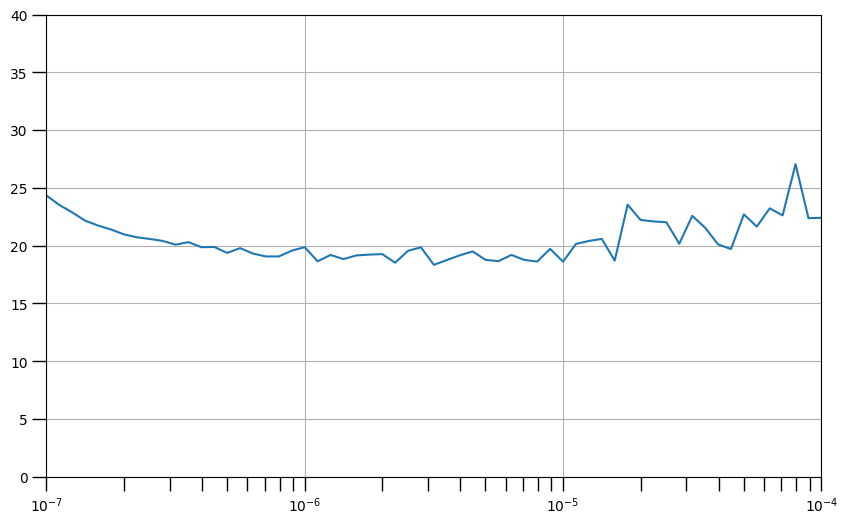

In [19]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-7, 1e-4, 0, 40])

## Train the Model

Now you can proceed to reset and train the model. It is set for 100 epochs in the cell below but feel free to increase it if you want. Laurence got his results in the lectures after 500.

In [20]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [21]:
# Set the learning rate
learning_rate = 8e-7

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [22]:
# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 56.3659 - mae: 56.8639
Epoch 2/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 28.2427 - mae: 28.7333

2024-07-11 16:23:46.783754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 26.1197 - mae: 26.6138
Epoch 3/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 21.2311 - mae: 21.7219

2024-07-11 16:23:47.950063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 21.7060 - mae: 22.1988
Epoch 4/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 19.1913 - mae: 19.6809

2024-07-11 16:23:49.040751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 20.0619 - mae: 20.5538
Epoch 5/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 18.8503 - mae: 19.3412

2024-07-11 16:23:50.142555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.6749 - mae: 20.1661
Epoch 6/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.6160 - mae: 19.1114

2024-07-11 16:23:51.235088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.0613 - mae: 19.5533
Epoch 7/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 17.8860 - mae: 18.3803

2024-07-11 16:23:52.378076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.2238 - mae: 19.7167
Epoch 8/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.6249 - mae: 17.1168

2024-07-11 16:23:53.519505: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.4272 - mae: 18.9202
Epoch 9/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 21.4687 - mae: 21.9580

2024-07-11 16:23:54.602265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.4729 - mae: 19.9646
Epoch 10/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 20.1455 - mae: 20.6343

2024-07-11 16:23:55.704050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 19.2547 - mae: 19.7460
Epoch 11/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 20.0745 - mae: 20.5707

2024-07-11 16:23:56.840962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 18.9696 - mae: 19.4631
Epoch 12/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 20.7229 - mae: 21.2192

2024-07-11 16:23:58.177477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.7887 - mae: 19.2808
Epoch 13/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 20.9855 - mae: 21.4749

2024-07-11 16:23:59.296360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 20.2282 - mae: 20.7207
Epoch 14/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.6478 - mae: 19.1429

2024-07-11 16:24:00.404081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.4698 - mae: 18.9624
Epoch 15/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 20.0154 - mae: 20.5023

2024-07-11 16:24:01.513080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.4322 - mae: 18.9218
Epoch 16/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.0459 - mae: 16.5350

2024-07-11 16:24:02.608223: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.1843 - mae: 18.6757
Epoch 17/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.7422 - mae: 18.2338

2024-07-11 16:24:03.730886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.9172 - mae: 18.4092
Epoch 18/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 20.3823 - mae: 20.8780

2024-07-11 16:24:04.848251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 18.4320 - mae: 18.9246
Epoch 19/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.1311 - mae: 16.6149

2024-07-11 16:24:06.217798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.3036 - mae: 17.7921
Epoch 20/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.4596 - mae: 17.9493

2024-07-11 16:24:07.337151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.6441 - mae: 18.1344
Epoch 21/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.9896 - mae: 18.4752

2024-07-11 16:24:08.467028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.5445 - mae: 19.0353
Epoch 22/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.7443 - mae: 16.2360

2024-07-11 16:24:09.560085: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.8690 - mae: 18.3599
Epoch 23/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.6243 - mae: 18.1088

2024-07-11 16:24:10.705404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.1804 - mae: 18.6708
Epoch 24/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.5000 - mae: 16.9865

2024-07-11 16:24:11.796491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.4022 - mae: 17.8916
Epoch 25/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.9171 - mae: 17.4043

2024-07-11 16:24:12.894376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.4356 - mae: 17.9234
Epoch 26/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 16.8556 - mae: 17.3503

2024-07-11 16:24:14.046642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.6833 - mae: 18.1746
Epoch 27/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.6285 - mae: 17.1221

2024-07-11 16:24:15.197674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.6604 - mae: 18.1517
Epoch 28/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.2730 - mae: 18.7547

2024-07-11 16:24:16.287124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.9739 - mae: 18.4625
Epoch 29/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 19.4890 - mae: 19.9803

2024-07-11 16:24:17.378039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.1269 - mae: 18.6174
Epoch 30/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.2773 - mae: 18.7643

2024-07-11 16:24:18.477897: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.9375 - mae: 18.4273
Epoch 31/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.2843 - mae: 17.7760

2024-07-11 16:24:19.577074: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.7847 - mae: 18.2772
Epoch 32/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.6117 - mae: 17.1019

2024-07-11 16:24:20.657859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.1191 - mae: 17.6089
Epoch 33/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.0711 - mae: 17.5631

2024-07-11 16:24:21.740226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.5444 - mae: 18.0361
Epoch 34/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 15.4113 - mae: 15.9039

2024-07-11 16:24:22.823836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.3596 - mae: 17.8503
Epoch 35/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.3738 - mae: 16.8688

2024-07-11 16:24:23.914264: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.4240 - mae: 17.9161
Epoch 36/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.4053 - mae: 16.9000

2024-07-11 16:24:25.002395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.3793 - mae: 17.8720
Epoch 37/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.7820 - mae: 16.2728

2024-07-11 16:24:26.082649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.2318 - mae: 17.7221
Epoch 38/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.8244 - mae: 17.3153

2024-07-11 16:24:27.222238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.4250 - mae: 17.9158
Epoch 39/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.1847 - mae: 17.6727

2024-07-11 16:24:28.313740: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.3671 - mae: 17.8575
Epoch 40/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.5274 - mae: 17.0183

2024-07-11 16:24:29.393584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.0623 - mae: 17.5528
Epoch 41/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.3425 - mae: 16.8333

2024-07-11 16:24:30.465153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.3007 - mae: 17.7910
Epoch 42/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 19.6173 - mae: 20.1038

2024-07-11 16:24:31.537643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.6661 - mae: 18.1556
Epoch 43/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.9635 - mae: 19.4562

2024-07-11 16:24:32.617618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.7293 - mae: 18.2207
Epoch 44/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 19.1035 - mae: 19.6010

2024-07-11 16:24:33.711269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.9318 - mae: 18.4243
Epoch 45/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.2326 - mae: 18.7207

2024-07-11 16:24:34.791486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.4504 - mae: 17.9411
Epoch 46/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.4175 - mae: 18.9128

2024-07-11 16:24:35.871847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.8238 - mae: 18.3153
Epoch 47/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.0379 - mae: 18.5190

2024-07-11 16:24:36.970201: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.4615 - mae: 17.9482
Epoch 48/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.7510 - mae: 16.2344

2024-07-11 16:24:38.064094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.8764 - mae: 17.3651
Epoch 49/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.2030 - mae: 16.6902

2024-07-11 16:24:39.148793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.9622 - mae: 17.4511
Epoch 50/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.9145 - mae: 18.3999

2024-07-11 16:24:40.229407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.8121 - mae: 18.3018
Epoch 51/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 14.8514 - mae: 15.3356

2024-07-11 16:24:41.313613: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.8232 - mae: 17.3120
Epoch 52/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.0257 - mae: 18.5121

2024-07-11 16:24:42.396643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.6611 - mae: 18.1497
Epoch 53/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.1580 - mae: 17.6550

2024-07-11 16:24:43.504064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.3577 - mae: 17.8488
Epoch 54/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.9790 - mae: 18.4754

2024-07-11 16:24:44.583252: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.6275 - mae: 18.1207
Epoch 55/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.2455 - mae: 16.7338

2024-07-11 16:24:45.656215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.8417 - mae: 18.3326
Epoch 56/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.4970 - mae: 17.9860

2024-07-11 16:24:46.740421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.2497 - mae: 17.7406
Epoch 57/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.7213 - mae: 18.2120

2024-07-11 16:24:47.818244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.8027 - mae: 18.2943
Epoch 58/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.5027 - mae: 16.9932

2024-07-11 16:24:48.910598: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.9954 - mae: 17.4855
Epoch 59/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.0548 - mae: 18.5408

2024-07-11 16:24:50.050511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.4140 - mae: 17.9032
Epoch 60/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.4759 - mae: 16.9678

2024-07-11 16:24:51.136813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.2095 - mae: 17.7009
Epoch 61/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.8406 - mae: 16.3262

2024-07-11 16:24:52.217682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.0351 - mae: 17.5241
Epoch 62/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.7983 - mae: 17.2885

2024-07-11 16:24:53.308307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.8931 - mae: 17.3819
Epoch 63/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 19.1353 - mae: 19.6245

2024-07-11 16:24:54.392833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18.2062 - mae: 18.6967
Epoch 64/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.5790 - mae: 17.0694

2024-07-11 16:24:55.472441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.3389 - mae: 17.8303
Epoch 65/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 15.7956 - mae: 16.2780

2024-07-11 16:24:56.563792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.1071 - mae: 17.5968
Epoch 66/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.3141 - mae: 16.8023

2024-07-11 16:24:57.655109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.7406 - mae: 17.2313
Epoch 67/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.7920 - mae: 16.2827

2024-07-11 16:24:58.751188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.2449 - mae: 17.7345
Epoch 68/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.8775 - mae: 16.3649

2024-07-11 16:24:59.851444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.7556 - mae: 17.2450
Epoch 69/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.4932 - mae: 18.9871

2024-07-11 16:25:00.937720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.3822 - mae: 17.8741
Epoch 70/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.2642 - mae: 16.7525

2024-07-11 16:25:02.024864: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.9417 - mae: 17.4301
Epoch 71/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.6630 - mae: 17.1460

2024-07-11 16:25:03.123243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.5280 - mae: 18.0175
Epoch 72/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.3406 - mae: 16.8243

2024-07-11 16:25:04.206344: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 17.2297 - mae: 17.7181
Epoch 73/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.4199 - mae: 18.9074

2024-07-11 16:25:05.470939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.8274 - mae: 18.3163
Epoch 74/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 16.8656 - mae: 17.3577

2024-07-11 16:25:06.598918: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.6485 - mae: 18.1388
Epoch 75/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 15.3513 - mae: 15.8430

2024-07-11 16:25:07.726674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.5501 - mae: 17.0424
Epoch 76/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 16.2308 - mae: 16.7221

2024-07-11 16:25:08.866919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.9240 - mae: 17.4145
Epoch 77/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 15.2541 - mae: 15.7420

2024-07-11 16:25:10.045134: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.0625 - mae: 17.5519
Epoch 78/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.2202 - mae: 18.7124

2024-07-11 16:25:11.168752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.4172 - mae: 17.9079
Epoch 79/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 15.8688 - mae: 16.3536

2024-07-11 16:25:12.331135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 16.8044 - mae: 17.2936
Epoch 80/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 19.5167 - mae: 20.0091

2024-07-11 16:25:13.558708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.2738 - mae: 17.7639
Epoch 81/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.7034 - mae: 17.1798

2024-07-11 16:25:14.669774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.3967 - mae: 16.8839
Epoch 82/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.3709 - mae: 16.8556

2024-07-11 16:25:15.779636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.2672 - mae: 17.7566
Epoch 83/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 14.3042 - mae: 14.7874

2024-07-11 16:25:16.891209: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 16.3534 - mae: 16.8415
Epoch 84/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 16.8810 - mae: 17.3715

2024-07-11 16:25:18.141279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.1537 - mae: 17.6437
Epoch 85/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.7323 - mae: 17.2275

2024-07-11 16:25:19.263198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.8302 - mae: 17.3211
Epoch 86/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.0367 - mae: 16.5266

2024-07-11 16:25:20.348392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.8531 - mae: 17.3429
Epoch 87/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.8023 - mae: 17.2903

2024-07-11 16:25:21.433614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.7585 - mae: 17.2487
Epoch 88/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.8921 - mae: 16.3769

2024-07-11 16:25:22.596586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.6404 - mae: 17.1288
Epoch 89/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.1082 - mae: 17.5945

2024-07-11 16:25:23.693169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.9121 - mae: 17.4009
Epoch 90/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 18.3504 - mae: 18.8427

2024-07-11 16:25:24.784793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.6817 - mae: 18.1722
Epoch 91/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 17.6356 - mae: 18.1228

2024-07-11 16:25:25.883251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 17.2856 - mae: 17.7756
Epoch 92/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.6379 - mae: 17.1276

2024-07-11 16:25:27.118152: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.1350 - mae: 17.6242
Epoch 93/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 19.4274 - mae: 19.9114

2024-07-11 16:25:28.242708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.3340 - mae: 17.8221
Epoch 94/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.7749 - mae: 16.2646

2024-07-11 16:25:29.356151: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.7240 - mae: 17.2126
Epoch 95/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 15.4156 - mae: 15.8947

2024-07-11 16:25:30.472704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 16.7113 - mae: 17.2011
Epoch 96/100
10/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 14.0629 - mae: 14.5429

2024-07-11 16:25:31.680614: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.7411 - mae: 17.2295
Epoch 97/100
 9/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 16.7746 - mae: 17.2628

2024-07-11 16:25:32.791163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.2004 - mae: 17.6910
Epoch 98/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 14.8725 - mae: 15.3689

2024-07-11 16:25:33.921343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 16.7794 - mae: 17.2708
Epoch 99/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 16.8718 - mae: 17.3602

2024-07-11 16:25:35.124058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.1018 - mae: 17.5918
Epoch 100/100
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 18.2885 - mae: 18.7776

2024-07-11 16:25:36.260814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.6722 - mae: 18.1610


2024-07-11 16:25:37.421356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


You can visualize the training and see if the loss and MAE are still trending down.

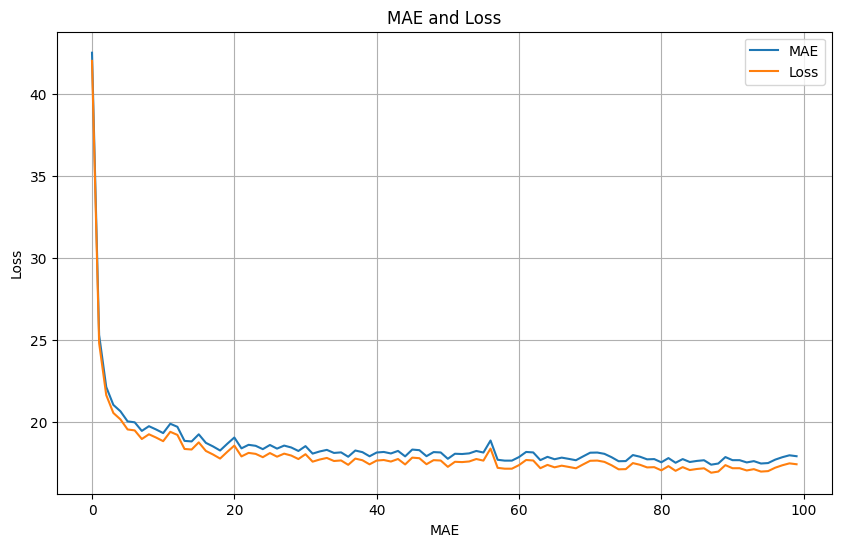

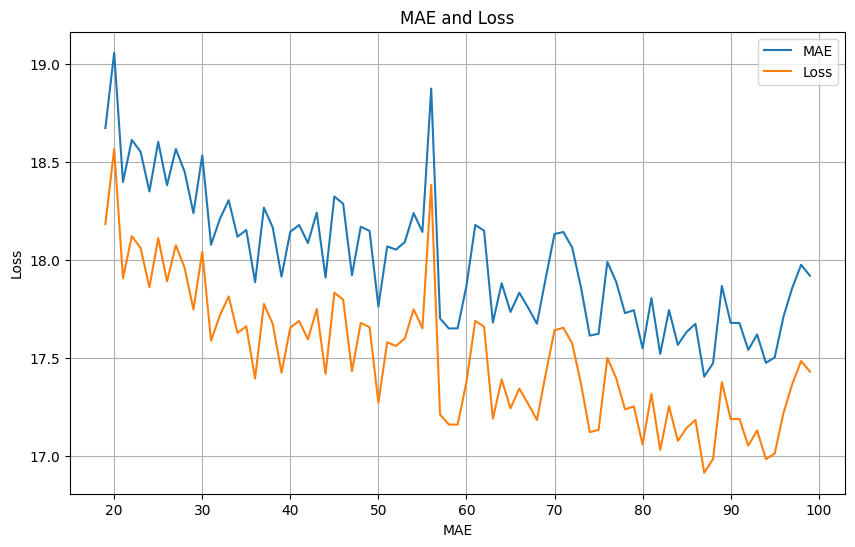

In [23]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

## Model Prediction

As before, you can get the predictions for the validation set time range and compute the metrics.

In [24]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2024-07-11 16:32:54.701819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


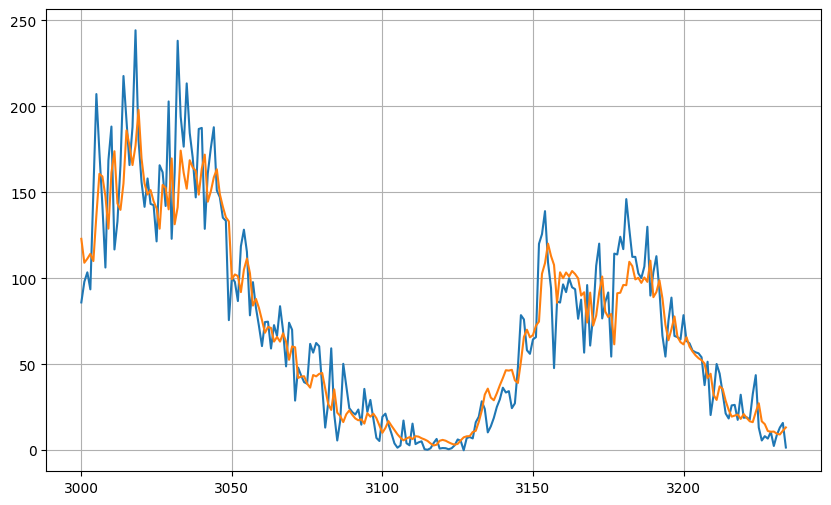

In [25]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [26]:
# Compute the MAE
print(tf.keras.metrics.mae(x_valid, results).numpy())

14.648899


## Wrap Up

This concludes the final practice lab for this course! You implemented a deep and complex architecture composed of CNNs, RNNs, and DNNs. You'll be using the skills you developed throughout this course to complete the final assignment. Keep it up!

## Optional

In this optional section, you will look at another way to dynamically set the learning rate. As you may have noticed, training for a long time generates less and less changes to the loss and metrics. You can run the cell below to observe that again.

In [27]:
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=10)

Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 16.5835 - mae: 17.0716
Epoch 2/10
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 17.1516 - mae: 17.6400

2024-07-11 16:33:25.979947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.6079 - mae: 17.0964
Epoch 3/10
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 16.0379 - mae: 16.5245

2024-07-11 16:33:27.097512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.7278 - mae: 17.2149
Epoch 4/10
 8/93 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 15.6431 - mae: 16.1261

2024-07-11 16:33:28.218534: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.4081 - mae: 16.8961
Epoch 5/10
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 16.0045 - mae: 16.4853

2024-07-11 16:33:29.364268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.7404 - mae: 17.2278
Epoch 6/10
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.1209 - mae: 15.6019

2024-07-11 16:33:30.474390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.2947 - mae: 16.7812
Epoch 7/10
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 15.1485 - mae: 15.6274

2024-07-11 16:33:31.574975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.4145 - mae: 16.8999
Epoch 8/10
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 17.0263 - mae: 17.5192

2024-07-11 16:33:32.679660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.5355 - mae: 17.0240
Epoch 9/10
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 17.5803 - mae: 18.0692

2024-07-11 16:33:33.808805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.8895 - mae: 17.3789
Epoch 10/10
 6/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 13.7315 - mae: 14.2140

2024-07-11 16:33:34.915084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 16.2741 - mae: 16.7606


2024-07-11 16:33:36.085562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


At some point, the static learning rate you set might no longer be the optimal one when the model has been learning for some time. You may want to decrease it some more to see better improvements. One way to do that is to have your training loop gradually decay the learning rate per epoch. You can pass in a lambda function similar like the one you did for the learning rate scheduler earlier, or use [ExponentialDecay()](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay). This is a built in scheduler from the Keras API. This decays the learning rate defined by this function:

```
def decayed_learning_rate(step):
  return initial_learning_rate * decay_rate ^ (step / decay_steps)
```

See how it is used below.

In [37]:
0.96**0.9

0.963926921258551

In [38]:
# Set the initial learning rate
initial_learning_rate=1e-7

# Define the scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=400,
    decay_rate=0.96,
    staircase=True)

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=40)

Epoch 1/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 16.7948 - mae: 17.2818
Epoch 2/40
 6/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 18.5365 - mae: 19.0297

2024-07-12 16:49:27.707115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.8884 - mae: 17.3786
Epoch 3/40
10/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 15.0797 - mae: 15.5705

2024-07-12 16:49:28.807520: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.4312 - mae: 16.9197
Epoch 4/40
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 15.6838 - mae: 16.1736

2024-07-12 16:49:29.855939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.3335 - mae: 16.8216
Epoch 5/40
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 17.6479 - mae: 18.1375

2024-07-12 16:49:30.906233: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.6940 - mae: 17.1812
Epoch 6/40
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 16.4439 - mae: 16.9360

2024-07-12 16:49:31.961044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.6589 - mae: 17.1468
Epoch 7/40
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 16.7838 - mae: 17.2718

2024-07-12 16:49:32.998182: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.6927 - mae: 17.1802
Epoch 8/40
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.4754 - mae: 16.9585

2024-07-12 16:49:34.034167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.7756 - mae: 17.2618
Epoch 9/40
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.5746 - mae: 18.0596

2024-07-12 16:49:35.071560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.0736 - mae: 17.5586
Epoch 10/40
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.8585 - mae: 18.3516

2024-07-12 16:49:36.192989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.9117 - mae: 17.4000
Epoch 11/40
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.1645 - mae: 18.6522

2024-07-12 16:49:37.229973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.2617 - mae: 17.7502
Epoch 12/40
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.3734 - mae: 16.8646

2024-07-12 16:49:38.270376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.7127 - mae: 17.2018
Epoch 13/40
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.2239 - mae: 17.7095

2024-07-12 16:49:39.307764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.7678 - mae: 17.2546
Epoch 14/40
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 14.5510 - mae: 15.0294

2024-07-12 16:49:40.344262: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.3005 - mae: 16.7863
Epoch 15/40
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 14.7940 - mae: 15.2756

2024-07-12 16:49:41.390425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.1997 - mae: 16.6878
Epoch 16/40
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.4893 - mae: 17.9705

2024-07-12 16:49:42.439769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.5298 - mae: 17.0176
Epoch 17/40
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.6686 - mae: 17.1508

2024-07-12 16:49:43.484173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.7223 - mae: 17.2096
Epoch 18/40
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.4298 - mae: 17.9177

2024-07-12 16:49:44.525952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.9363 - mae: 17.4244
Epoch 19/40
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.8623 - mae: 16.3494

2024-07-12 16:49:45.627209: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.2388 - mae: 16.7268
Epoch 20/40
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.2812 - mae: 17.7675

2024-07-12 16:49:46.673745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.8336 - mae: 17.3208
Epoch 21/40
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.3763 - mae: 15.8535

2024-07-12 16:49:47.715282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.2537 - mae: 16.7382
Epoch 22/40
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.9600 - mae: 16.4479

2024-07-12 16:49:48.762265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.4469 - mae: 16.9326
Epoch 23/40
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.2198 - mae: 17.7061

2024-07-12 16:49:49.806075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.7962 - mae: 17.2839
Epoch 24/40
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.1107 - mae: 15.5961

2024-07-12 16:49:50.852115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.3711 - mae: 16.8577
Epoch 25/40
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.1294 - mae: 15.5992

2024-07-12 16:49:51.900756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.4382 - mae: 16.9225
Epoch 26/40
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.4258 - mae: 16.9177

2024-07-12 16:49:52.946093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.4043 - mae: 16.8916
Epoch 27/40
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.5845 - mae: 18.0767

2024-07-12 16:49:53.994032: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.7248 - mae: 17.2114
Epoch 28/40
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.5103 - mae: 18.0020

2024-07-12 16:49:55.043747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.6018 - mae: 17.0902
Epoch 29/40
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.0413 - mae: 16.5273

2024-07-12 16:49:56.139466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.3897 - mae: 16.8769
Epoch 30/40
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.9152 - mae: 16.4023

2024-07-12 16:49:57.197431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.3941 - mae: 16.8813
Epoch 31/40
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 16.3302 - mae: 16.8185

2024-07-12 16:49:58.253701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.2957 - mae: 16.7830
Epoch 32/40
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.7522 - mae: 18.2397

2024-07-12 16:49:59.305451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 17.1377 - mae: 17.6258
Epoch 33/40
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 14.6377 - mae: 15.1214

2024-07-12 16:50:00.359951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.2551 - mae: 16.7433
Epoch 34/40
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.7358 - mae: 16.2158

2024-07-12 16:50:01.415756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.5520 - mae: 17.0394
Epoch 35/40
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 14.6934 - mae: 15.1753

2024-07-12 16:50:02.475630: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.2628 - mae: 16.7484
Epoch 36/40
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.2973 - mae: 15.7833

2024-07-12 16:50:03.532861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.4294 - mae: 16.9165
Epoch 37/40
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 14.0623 - mae: 14.5373

2024-07-12 16:50:04.617643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.0724 - mae: 16.5585
Epoch 38/40
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 14.7439 - mae: 15.2336

2024-07-12 16:50:05.695527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.1752 - mae: 16.6632
Epoch 39/40
11/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 14.7826 - mae: 15.2648

2024-07-12 16:50:06.764047: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.3386 - mae: 16.8248
Epoch 40/40
10/93 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 13.9716 - mae: 14.4557

2024-07-12 16:50:07.833389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 16.0230 - mae: 16.5097


2024-07-12 16:50:08.913247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Now see the results by geting predicitons and computing the metrics.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


2024-07-12 16:50:10.423925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


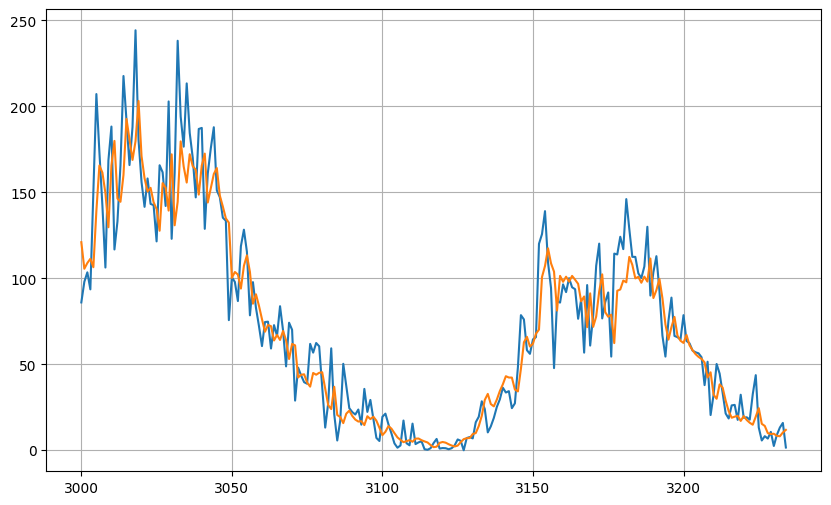

In [39]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [40]:
# Compute the MAE
tf.keras.metrics.mae(x_valid, results).numpy()

14.120785